Code to generate Figure 5(c) in 'Rethinking Discount Regularization'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
#import seaborn as sns
import torch
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Define MDP

In [ ]:
def in_bounds(coords,grid_xdim,grid_ydim):

  """Helper function for define_mdp

  If hit wall, do not move.

  """

  #if coords [row,col]
  if coords[0] > grid_xdim - 1:
    coords[0] = grid_xdim -1
  elif coords[0] < 0:
    coords[0] = 0

  if coords[1] > grid_ydim - 1:
    coords[1] = grid_ydim-1
  elif coords[1] < 0:
    coords[1] = 0

  return coords

In [ ]:
def define_mdp():
  """ GridWorld Environment

  * from http://proceedings.mlr.press/v119/amit20a/amit20a-supp.pdf
  * if hit wall, do not move

  modification: random state instaed of stay

  """
  grid_xdim = 4
  grid_ydim = 4
  num_states = grid_xdim*grid_ydim

  #actions
  actions = {
    'N': np.array([-1,0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
    }
  num_actions = len(actions)


  #transition matrix
  T = np.zeros((num_actions,num_states,num_states))
  for s in range(num_states):

    p_s = np.random.uniform(0,1)

    #convert to x,y coords
    s_coords = np.unravel_index(s,(grid_xdim,grid_ydim))

    #North = action 0
    s_prime_coords = in_bounds(s_coords + actions['N'],grid_xdim,grid_ydim)  # get coords of next state
    # convert to number
    s_prime = np.ravel_multi_index(tuple(s_prime_coords),(grid_xdim,grid_ydim))
    T[0,s,s_prime] += p_s
    s_random = np.random.randint(0,num_states-1)
    T[0,s,s_random] += 1-p_s

    #S = action 1
    s_prime_coords = in_bounds(s_coords + actions['S'],grid_xdim,grid_ydim)  # get coords of next state
    # convert to number
    s_prime = np.ravel_multi_index(tuple(s_prime_coords),(grid_xdim,grid_ydim))
    T[1,s,s_prime] += p_s
    s_random = np.random.randint(0,num_states-1)
    T[1,s,s_random] += 1-p_s

    #E = action 2
    s_prime_coords = in_bounds(s_coords + actions['E'],grid_xdim,grid_ydim)  # get coords of next state
    # convert to number
    s_prime = np.ravel_multi_index(tuple(s_prime_coords),(grid_xdim,grid_ydim))
    T[2,s,s_prime] += p_s
    s_random = np.random.randint(0,num_states-1)
    T[2,s,s_random] += 1-p_s


    #W = action 3
    s_prime_coords = in_bounds(s_coords + actions['W'],grid_xdim,grid_ydim)  # get coords of next state
    # convert to number
    s_prime = np.ravel_multi_index(tuple(s_prime_coords),(grid_xdim,grid_ydim))
    T[3,s,s_prime] += p_s
    s_random = np.random.randint(0,num_states-1)
    T[3,s,s_random] += 1-p_s

  #define Reward function
  high_r_state = np.random.choice(16,replace=False)
  R = np.zeros(num_states)
  for r in range(num_states):
    if r==high_r_state:
      R[r]=1
    else:
      R[r] = np.random.uniform(-.5,.5)

  return T,R

#t,r = define_mdp()

## Dynamic Programming

In [ ]:
def eval_policy(gamma,policy,T_list,R_list,theta):
  """Policy evaluation
  """

  num_states = T_list[0].shape[0]

  index = list(zip(policy,range(num_states)))
  #T=[]
  #for t in T_list:
  #    T.append(t.tolist())

  T_pi = np.matrix([T_list[i][j] for (i,j) in index])
  R_pi = np.transpose(np.matrix(R_list))

  #value = np.dot(np.linalg.inv(np.eye(num_states)-gamma*T_pi),`R_pi)
  #value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,np.eye(num_states))@R_pi
  value = np.linalg.solve(np.eye(num_states)-gamma*T_pi,R_pi)

  return value

def value_iter(gamma, T_list,R_list, theta = .0001):
  """Value Iteration
  """
  num_states = len(R_list)

  T = torch.tensor(np.array([np.array(x) for x in T_list]))
  R = torch.tensor(np.array(R_list))


  #V = torch.tensor(np.zeros(10))
  V = torch.tensor(np.random.uniform(0,1,num_states))
  delta = 10.

  while delta > theta:
      v = V
      V = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).values
      delta= torch.max(torch.abs(v-V)).item()


  #get greedy policy
  P = torch.max(R + gamma*torch.einsum("bij,j->bi", T, V),dim=0).indices

  return P.tolist(),np.transpose(np.matrix(V))


## Generate Data Set

In [ ]:
# sample data from MDP
#generate trajectories starting at S

def gen_trajectory(T_list,R_list,start_state_weights,action_weights,len_traj):

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    traj = []
    obs_rewards = [ [] for i in range(num_states)]

    actions = []

    all_states = range(num_states)
    state = np.random.choice(all_states,1,True,start_state_weights)[0]  # start at random state with uniform prob
    traj.append(state)

    while len(traj)<len_traj:

        # choose random action
        action = np.random.choice(all_actions,p=action_weights)
        actions.append(action)

        for a in all_actions:
            if action == a:
                t_probs = T_list[a][state].tolist()
        cum_tprobs = np.cumsum(t_probs)
        rand_num = np.random.uniform()
        for j in range(num_states):
            if rand_num < cum_tprobs[j]:
                state = j
                break
        traj.append(state)

        rew_stdev = .1*abs(R_list[state])
        obs_rewards[state].append(np.random.normal(R_list[state],rew_stdev))

    return actions,traj,obs_rewards


#gen dataset of trajectories
def gen_data(num_traj,T_list,R_list,start_state_weights,len_traj,exact=False):

    #num_traj is number of trajectories in the data set TOTAL

    num_states = T_list[0].shape[0]
    num_actions = len(T_list)
    all_actions = range(num_actions)

    sa_count_list = []
    for a in all_actions:
        sa_count_list.append(np.zeros((num_states,num_states)))

    r_counts = [ [] for i in range(num_states)]

    act_weights = [1./num_actions for n in range(num_actions)]

    if exact == False:

        for i in range(num_traj):
            actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights,act_weights,len_traj)

            for j in range(len(actions)):
                state_1 = traj[j]
                state_2 = traj[j+1]
                action = actions[j]

                for a in all_actions:
                    if action == a:
                        sa_count_list[a][state_1,state_2]+=1

            r_counts = [m+n for m,n in zip(rew,r_counts)]

    else:
        start_state_nums = [int(u*num_traj/num_actions) for u in start_state_weights]
        for state in range(num_states):

            start_state_weights_exact= np.zeros(num_states)
            start_state_weights_exact[state] = 1

            for a in range(num_actions):
                act_weights = np.zeros(len(T_list))
                act_weights[a] = 1

                for j in range(start_state_nums[state]):
                    actions,traj,rew = gen_trajectory(T_list,R_list,start_state_weights_exact,act_weights,len_traj)
                    for j in range(len(actions)):
                        state_1 = traj[j]
                        state_2 = traj[j+1]
                        action = actions[j]

                        for a in all_actions:
                            if action == a:
                                sa_count_list[a][state_1,state_2]+=1

                    r_counts = [m+n for m,n in zip(rew,r_counts)]

    for a in all_actions:
        sa_count_list[a] = np.matrix(sa_count_list[a])

    return sa_count_list,r_counts

## Estimate MDP

In [ ]:
#Estimate MDP
# default T if no data: uniform
# default R if no data: 0

def mle_estimate_mdp(count_matrix_list,rew_list):

    num_states = count_matrix_list[0].shape[0]
    all_actions = range(len(count_matrix_list))

    #estimate transition matrix from data

    #assume equal probability to all states as default if no data
    default = (1./num_states)*np.ones(num_states)

    T_hat_list = []
    for a in all_actions:
        T_hat_list.append(np.zeros((num_states,num_states))) #transition matrix under action a

    for i in range(num_states):

        for act in all_actions:
            sum_act = count_matrix_list[act][i].sum(axis=1)

            if sum_act == 0: # never visited state i and took action "act"
                T_hat_list[act][i] = default
            else:
                T_hat_list[act][i] = (1./sum_act)*count_matrix_list[act][i]

    #estimate reward from data
    R_hat = [np.average(r) for r in rew_list]
    R_hat = np.where(np.isnan(R_hat),0,R_hat) #assume R_hat = 0 if no data for state

    for a in all_actions:
        T_hat_list[a] = np.matrix(T_hat_list[a])

    return T_hat_list,R_hat

## Regularization

In [ ]:
#create regularized estimates

def epsilon_greedy(eps,T_hat_list):
    T_reg_list = []
    num_actions = len(T_hat_list)
    T_eg = (1./num_actions)*sum(T_hat_list)  #average of all actions, for epsilon-stochastic
    for T_hat in T_hat_list:
        T_reg_list.append((1-eps)*T_hat + eps*T_eg)
    return T_reg_list

def uniform_prior(eps,sa_count_list):
    T_unif_list = []
    num_states = sa_count_list[0].shape[0]
    num_actions = len(sa_count_list)
    unif_prior = np.ones((num_states,num_states))

    total_sa_count = 0
    for sa_count in sa_count_list:
      total_sa_count += np.sum(sa_count)
    avg_count = total_sa_count/(num_states*num_actions)
    mag = eps/(1-eps)*avg_count/num_states

    for sa_count in sa_count_list:
        if eps == 1:
            alpha_post = 0*sa_count+unif_prior
        else:
            alpha_post = sa_count + mag*unif_prior

        T_post = np.zeros((num_states,num_states))
        default = (1./num_states)*np.ones(num_states) #uniform default, as above
        for i in range(num_states):
            sum_state = (alpha_post[i].sum(axis=1)).item()
            if sum_state == 0: # never visited state i and took action "act"
                T_post[i] = default
            else:
                T_post[i] = (1./sum_state)*alpha_post[i]
        T_unif_list.append(T_post)

    return T_unif_list


### State-specific Regularization

In [ ]:
def epsilon_star_unif(T_sa,num_samples):
  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon if we knew true value of T

  """
  num_states = len(T_sa)
  numerator = 0
  denominator = 0
  for s_prime in range(num_states):
    numerator += (1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])
    denominator += ((1./num_samples)*T_sa[s_prime]*(1-T_sa[s_prime]) + T_sa[s_prime]**2 - 2/num_states*T_sa[s_prime] + 1/(num_states**2))
  return numerator/denominator

In [ ]:
def mse_unif(T_sa,epsilon,num_samples):
  mse = 0
  num_states = len(T_sa)
  for s_prime in range(num_states):
    mse += (1-epsilon)**2*(1/num_samples)*T_sa[s_prime]*(1-T_sa[s_prime])+epsilon**2*((1/num_states)-T_sa[s_prime])**2

  return mse

In [ ]:
def epsilon_star_hat_unif(sa_count_list):

  """Calculate optimal value of epsilon for uniform prior

  Optimal epsilon for single s-a pair for when we do not know true T

  """
  prior_mag = .25
  epsilon_list = np.linspace(0,1,100)
  num_resamples = 100

  max_mse_by_eps = []
  mean_mse_by_eps = []
  mse = 0
  num_samples = sum(sa_count_list)

  #define posterior. T_sa ~ dirichlet(alpha)
  scale = 100 #need to set this!
  alpha = tuple(x+prior_mag for x in sa_count_list)
  for e in epsilon_list:

    mse_list = []
    for n in range(num_resamples):

      #sample new T-hat from posterior
      T_samp = np.random.dirichlet(alpha)

      #calc MSE
      try:
        mse = mse_unif(T_samp,e,num_samples)
      except:
        mse = mse_unif(T_samp,e,1)
      mse_list.append(mse)

    #max_mse_by_eps.append(max(mse_list))
    mean_mse_by_eps.append(np.mean(mse_list))

  #min_index = max_mse_by_eps.index(min(max_mse_by_eps))
  min_index = mean_mse_by_eps.index(min(mean_mse_by_eps))

  return epsilon_list[min_index]

In [ ]:
def T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=False):

  num_states = T_mle_list[0].shape[0]
  num_actions = len(T_mle_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      #print('state',row_num)
      num_sa_samples = num_samples_a[row_num][0]
      if cross_validate==True:
        eps_sa = epsilon_star_hat_unif(sa_count_list[a].tolist()[row_num])
        #print('eps_sa',eps_sa)
      else:
        try:
          eps_sa = epsilon_star_unif(T_mle_list[a].tolist()[row_num],num_sa_samples)
          #print('eps_sa',eps_sa)
        except:
          eps_sa = 1
          #print('no data')

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

In [ ]:
def T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list):

  """State-specific regularization calculating epsilon* using true T

  (Theoretical minimum loss using our method)

  """
  num_states = T_list[0].shape[0]
  num_actions = len(T_list)
  T_reg_list = []
  T_unif = (1./num_states)*np.ones(num_states)

  T_sa_reg_list = [] #list of regularized transition matrixes for each action
  for a in range(num_actions):
    T_sa_reg = [] #action a regularized matrix
    num_samples_a = sa_count_list[a].sum(axis=1).tolist()
    for row_num in range(num_states):
      num_sa_samples = num_samples_a[row_num][0]
      if num_sa_samples > 0:
        eps_sa = epsilon_star_unif(T_list[a].tolist()[row_num],num_sa_samples)
      else:
        eps_sa = 1

      T_sa_reg.append([(1-eps_sa)*x + eps_sa*y for (x,y) in zip(T_mle_list[a].tolist()[row_num],T_unif)])
    T_sa_reg_list.append(np.matrix(T_sa_reg))

  return T_sa_reg_list

## Loss by epsilon for Plot

In [ ]:
def calc_loss(epsilon_list, num_traj=5, len_traj = 2,num_datasets=100):

    gamma_eval = 0.99
    theta = .01

    T_list,R_list = define_mdp()

    num_states = len(R_list)
    start_state_weights_data = (1./num_states)*np.ones(num_states)
    start_state_weights = (1./num_states)*np.ones(num_states) #evalulation


    #store loss for each value of epsilon
    loss_dict_disc = {} #discount regularization
    #loss_dict_eg = {} #epsilon-greedy regularization
    loss_dict_unif = {} #uniform prior
    for e in epsilon_list:
        loss_dict_disc[e] = [] #discountf regularization
        #loss_dict_eg[e] = [] #epsilon-greedy regularization
        loss_dict_unif[e] = [] #uniform prior

    loss for state-specfic
    loss_list_unif_ss_cv = []
    loss_list_unif_ss_trueT = []

    for n in range(num_datasets):

        T_list,R_list = define_mdp()

        #true optimal policy
        p,v = value_iter(gamma_eval,T_list,R_list,theta)

        #data set of trajectories
        sa_count_list,r_counts = gen_data(num_traj,T_list=T_list,R_list=R_list,start_state_weights=start_state_weights_data,len_traj=len_traj,exact=False)

        T_mle_list,R_mle = mle_estimate_mdp(sa_count_list,r_counts)

        #state specific epsilon losses - unif WITH CV
        T_unif_ss_list = T_reg_unif_per_state(T_mle_list,sa_count_list,cross_validate=True)
        p_unif_ss,v_unif_ss = value_iter(gamma_eval,T_unif_ss_list,R_list)
        v_unif_ss = eval_policy(gamma_eval,p_unif_ss,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss = v - v_unif_ss
        loss_unif_ss_flattened = [item.item() for sublist in loss_unif_ss for item in sublist]
        loss_unif_ss = np.average(loss_unif_ss_flattened,axis=None,weights=start_state_weights)
        loss_list_unif_ss_cv.append(loss_unif_ss)

        #state specific - Using true T to get theoretical min loss
        T_unif_ss_list2 = T_reg_unif_per_state_trueT(T_list,T_mle_list,sa_count_list)
        p_unif_ss2,v_unif_ss2 = value_iter(gamma_eval,T_unif_ss_list2,R_list)
        v_unif_ss2 = eval_policy(gamma_eval,p_unif_ss2,T_list,R_list,theta) #calculate value of policy in true MDP
        loss_unif_ss2 = v - v_unif_ss2
        loss_unif_ss_flattened2 = [item.item() for sublist in loss_unif_ss2 for item in sublist]
        loss_unif_ss2 = np.average(loss_unif_ss_flattened2,axis=None,weights=start_state_weights)
        loss_list_unif_ss_trueT.append(loss_unif_ss2)


        for e in epsilon_list:

            T_hat_eg = epsilon_greedy(e,T_mle_list)
            T_hat_unif = uniform_prior(e,sa_count_list)

            #calculate optimal policy and its value for regularized MDPs
            #assume R known
            p_disc,v_disc = value_iter((1-e)*gamma_eval,T_mle_list,R_list,theta)
            p_eg,v_eg = value_iter(gamma_eval,T_hat_eg,R_list,theta)
            p_unif,v_unif = value_iter(gamma_eval,T_hat_unif,R_list,theta)


            #calculate value of policies above using true MDP
            v_disc = eval_policy(gamma_eval,p_disc,T_list,R_list,theta)
            v_eg = eval_policy(gamma_eval,p_eg,T_list,R_list,theta)
            v_unif = eval_policy(gamma_eval,p_unif,T_list,R_list,theta)

            #loss = expected value over starting state distrib
            loss_disc = v - v_disc
            loss_disc_flattened = [item.item() for sublist in loss_disc for item in sublist]
            loss_eg = v - v_eg
            #loss_eg_flattened = [item.item() for sublist in loss_eg for item in sublist]
            loss_unif = v - v_unif
            loss_unif_flattened = [item.item() for sublist in loss_unif for item in sublist]

            loss_dict_disc[e].append(np.average(loss_disc_flattened,axis=None,weights=start_state_weights))
            #loss_dict_eg[e].append(np.average(loss_eg_flattened,axis=None,weights=start_state_weights))
            loss_dict_unif[e].append(np.average(loss_unif_flattened,axis=None,weights=start_state_weights))

        if n%10==0:
          print(n)
          #save off current results
          with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_disc_18len2.pkl', 'wb') as f:
            pickle.dump(loss_dict_disc, f)
          with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_unif_18len2.pkl', 'wb') as f:
            pickle.dump(loss_dict_unif, f)
          with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_cv_18len2.pkl', 'wb') as f:
            pickle.dump(loss_list_unif_ss_cv, f)
          with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_trueT_18len2.pkl', 'wb') as f:
            pickle.dump(loss_list_unif_ss_trueT, f)

    #mean loss
    mean_loss_disc = []
    #mean_loss_eg = []
    mean_loss_unif = []
    for e in epsilon_list:
        mean_loss_disc.append(np.mean(loss_dict_disc[e]))
        #mean_loss_eg.append(np.mean(loss_dict_eg[e]))
        mean_loss_unif.append(np.mean(loss_dict_unif[e]))

    #stdev loss of MEAN loss
    stdev_loss_disc = []
    #stdev_loss_eg = []
    stdev_loss_unif = []
    for e in epsilon_list:
        stdev_loss_disc.append(np.std(loss_dict_disc[e])/np.sqrt(num_datasets))
        #stdev_loss_eg.append(np.std(loss_dict_eg[e])/np.sqrt(num_datasets))
        stdev_loss_unif.append(np.std(loss_dict_unif[e])/np.sqrt(num_datasets))

    mean_ss_cv = np.mean(loss_list_unif_ss_cv)
    stdev_ss_cv = np.std(loss_list_unif_ss_cv)/np.sqrt(num_datasets)
    mean_ss_trueT = np.mean(loss_list_unif_ss_trueT)
    stdev_ss_trueT = np.std(loss_list_unif_ss_trueT)/np.sqrt(num_datasets)

    with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_disc_18len2.pkl', 'wb') as f:
      pickle.dump(loss_dict_disc, f)
    with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_unif_18len2.pkl', 'wb') as f:
      pickle.dump(loss_dict_unif, f)
    with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_cv_18len2.pkl', 'wb') as f:
      pickle.dump(loss_list_unif_ss_cv, f)
    with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_trueT_18len2.pkl', 'wb') as f:
      pickle.dump(loss_list_unif_ss_trueT, f)

    return mean_loss_disc,mean_loss_unif,stdev_loss_disc,stdev_loss_unif,mean_ss_cv,stdev_ss_cv,mean_ss_trueT,stdev_ss_trueT

# Figure for paper

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_datasets = 5000

len_traj = 2
num_traj = 18

mean_loss_disc,mean_loss_unif,stdev_loss_disc,stdev_loss_unif,mean_ss_cv,stdev_ss_cv,mean_ss_trueT,stdev_ss_trueT = calc_loss(epsilon_list,num_traj,len_traj,num_datasets)

In [ ]:
with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_disc_18len2.pkl', 'rb') as f:
  loss_dict_disc = pickle.load(f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_dict_unif_18len2.pkl', 'rb') as f:
  loss_dict_unif = pickle.load(f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_cv_18len2.pkl', 'rb') as f:
  loss_list_unif_ss_cv = pickle.load(f)
with open('/content/gdrive/My Drive/RegularizationJournalPlots/amit_loss_list_unif_ss_trueT_18len2.pkl', 'rb') as f:
  loss_list_unif_ss_trueT = pickle.load(f)
  print(len(loss_list_unif_ss_trueT))

In [ ]:
epsilon_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
num_ds = len(loss_list_unif_ss_trueT)

#mean loss
mean_loss_disc = []
mean_loss_unif = []
stdev_loss_disc = []
stdev_loss_unif = []
for e in epsilon_list:
  mean_loss_disc.append(np.mean(loss_dict_disc[e][:num_ds]))
  stdev_loss_disc.append(np.std(loss_dict_disc[e][:num_ds])/np.sqrt(num_ds))
  mean_loss_unif.append(np.mean(loss_dict_unif[e][:num_ds]))
  stdev_loss_unif.append(np.std(loss_dict_unif[e][:num_ds])/np.sqrt(num_ds))

#mean state-specific
mean_ss_cv = np.mean(loss_list_unif_ss_cv[:num_ds])
mean_ss_trueT = np.mean(loss_list_unif_ss_trueT[:num_ds])

#stdev state-specific
stdev_ss_cv = np.std(loss_list_unif_ss_cv[:num_ds])/np.sqrt(num_ds)
stdev_ss_trueT = np.std(loss_list_unif_ss_trueT[:num_ds])/np.sqrt(num_ds)

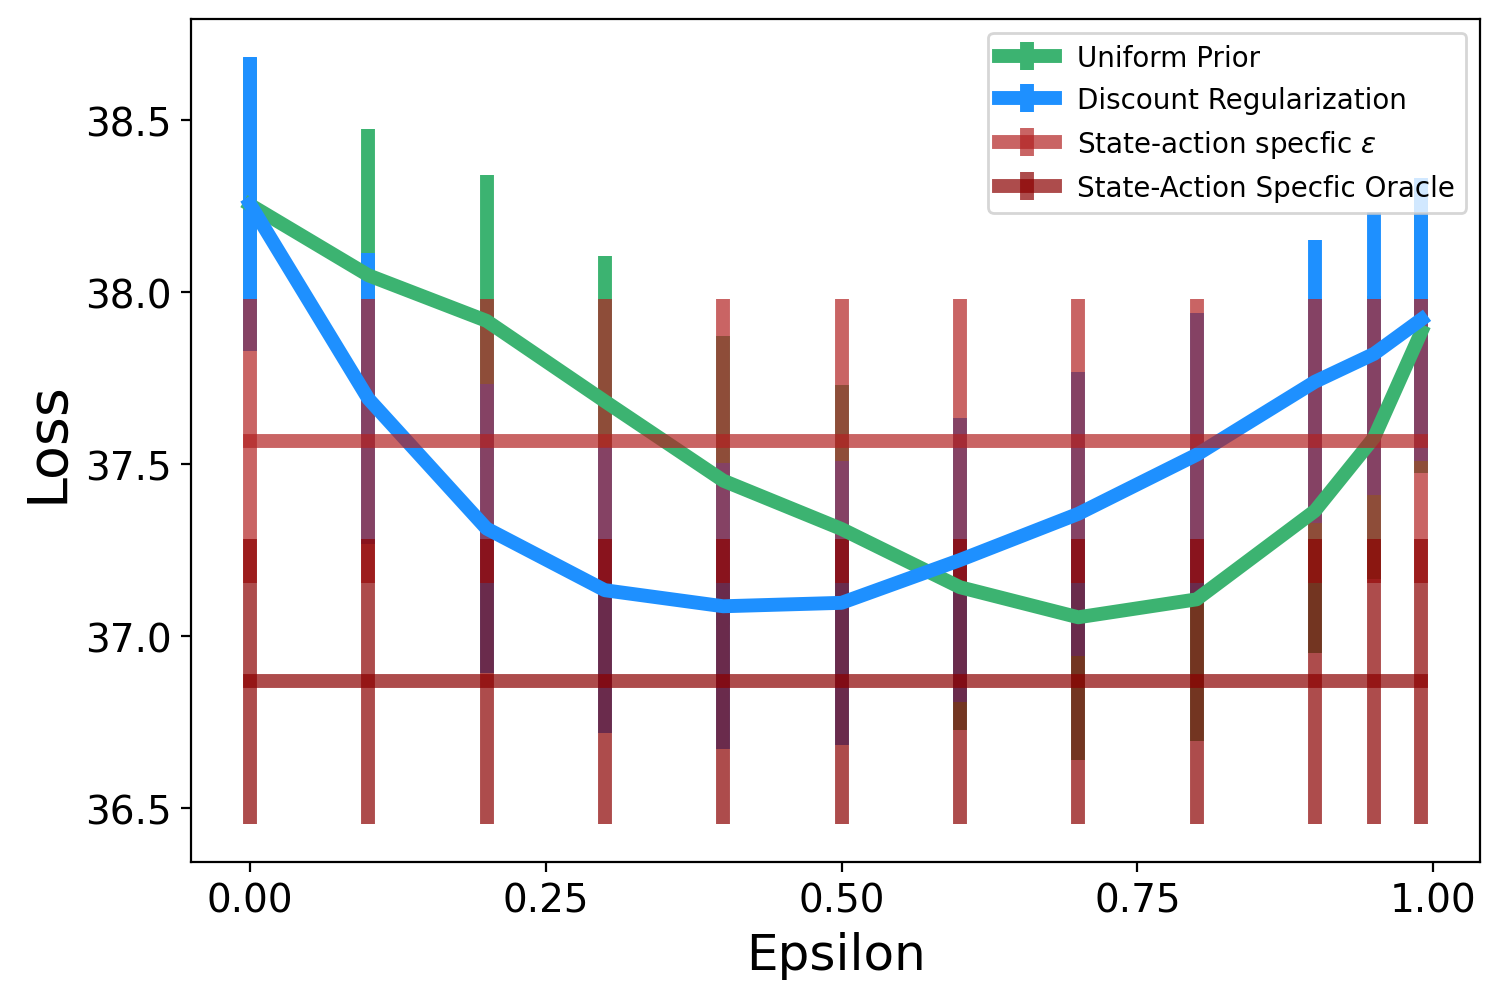

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6),dpi=200)
ax.errorbar(epsilon_list, mean_loss_unif, yerr=[2*j for j in stdev_loss_unif],linewidth = 5.0,color='mediumseagreen',label = 'Uniform Prior')
ax.errorbar(epsilon_list, mean_loss_disc, yerr=[2*j for j in stdev_loss_disc],linewidth = 5.0,color='dodgerblue',label = 'Discount Regularization')
ax.errorbar(epsilon_list,[mean_ss_cv for i in epsilon_list],yerr=[2*stdev_ss_cv for j in epsilon_list],color='firebrick',linewidth = 5.0,alpha = .7,label = r"State-action specfic $\epsilon$")
ax.errorbar(epsilon_list,[mean_ss_trueT for i in epsilon_list],yerr=[2*stdev_ss_trueT for j in epsilon_list],color='darkred',linewidth = 5.0,alpha = .7, label = r"State-Action Specfic Oracle")

ax.set_xlabel("Epsilon",fontsize=18)
ax.set_ylabel("Loss",fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Loss",fontsize=20)
ax.legend()

fig.tight_layout(rect=[0.05, 0, 1, 0.85])